# Analysis: Illusory Pitch

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

# Set file paths
TRIAL_DATAFILE = '../data/response_data.csv'
SCORES_DATAFILE = '../data/scores.csv'
SUBJ_SCORES_DATAFILE = '../data/subj_scores.csv'
FIGURE_PATH = './figures/'

### Define figure style

In [2]:
THEME = 'light'

# Set line widths and marker sizes
lw = 1.5
capsize = 3
msize = 7

# Set colors for light and dark versions of figures
if THEME == 'dark':
    background_color = '#151619'
    text_color = 'w'
    color1 = '#90E6E2'
    color2 = '#FAB2B9'
elif THEME == 'light':
    background_color = 'w'
    text_color = 'k'
    color1 = '#512D6D'
    color2 = '#F8485E'
else:
    raise ValueError('Theme not recognized - must be one of "light" or "dark".')

plt.rcParams.update({
    # BACKGROUND
    'figure.facecolor': background_color,
    'axes.facecolor': background_color,
    'savefig.facecolor': background_color,

    # TEXT
    'text.color': text_color,
    'axes.labelcolor': text_color,
    'xtick.color': text_color,
    'ytick.color': text_color,
    'figure.titlesize': 20,  # fontsize of the figure title
    'axes.titlesize': 20,
    'axes.labelsize': 16,  # fontsize of the x and y labels
    'xtick.labelsize': 12,  # fontsize of the tick labels
    'ytick.labelsize': 12,  # fontsize of the tick labels
    'legend.fontsize': 12,  # legend fontsize
    'legend.title_fontsize': 14,  # legend title size
    'font.size': 12,  # text size

    # FIGURE STYLE
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.edgecolor': text_color,
    'axes.grid': False,
    'ytick.left': True,
    'xtick.bottom': True
})

### Screen for above-chance performance

In [3]:
EXCLUDED = []
data = pd.read_csv(TRIAL_DATAFILE)

for i, subj in enumerate(data.subject.unique()):
    subj_data = data[data.subject == subj]
    num_correct = subj_data.correct.sum()
    num_possible = len(subj_data)
    if num_possible != 240:
        raise ValueError('Number of trials with nonzero offset should be 288. Subject %s has %i.' % (subj, num_possible))
    p = stats.binomtest(num_correct, n=num_possible, p=.5, alternative='greater').pvalue
    if p >= .05:
        print('Subject %s did not perform above chance (acc=%.4f, p=%.4f)!' % (subj, num_correct / num_possible, p))
        EXCLUDED.append(subj)

i = -1
p = 1
while p >= .05:
    i += 1
    p = stats.binomtest(i, n=240, p=.5, alternative='greater').pvalue
print('Min correct:', i)
print('Min accuracy:', i/240)

Subject 13 did not perform above chance (acc=0.5292, p=0.2007)!
Subject 15 did not perform above chance (acc=0.4750, p=0.7993)!
Subject 22 did not perform above chance (acc=0.4208, p=0.9942)!
Subject 31 did not perform above chance (acc=0.5542, p=0.0532)!
Subject 35 did not perform above chance (acc=0.5250, p=0.2389)!
Min correct: 134
Min accuracy: 0.5583333333333333


### Plot percent of probes rated "higher"

In [4]:
# Load trial data
data = pd.read_csv(TRIAL_DATAFILE)
data = data[~np.isin(data.subject, EXCLUDED)]

# Loftus & Masson (1994) method of plotting within-subject effects
subj_means = data.groupby('subject').mean(numeric_only=True).reset_index()
grand_mean = subj_means.mean()
within_data = data.copy()
for i, subj in enumerate(subj_means.subject):
    within_data.loc[within_data.subject == subj, 'response'] -= subj_means.response[i] - grand_mean.response

# Stagger the x-axis values so error bars will be easier to read
within_data.loc[within_data.pitch_shift == '+', 'offset'] -= .5
within_data.loc[within_data.pitch_shift == '-', 'offset'] += .5

In [5]:
# colour palette for pitch shift differences
color3 = '#00CED1' #Dark turquoise
color4 = '#D11141' #Dark pink

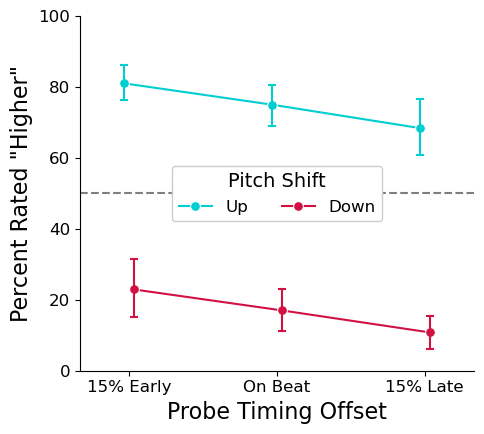

In [6]:
sns.lineplot(x='offset', y='response', hue='pitch_shift', data=within_data.groupby(['subject', 'offset', 'pitch_shift']).response.mean().reset_index(),
             ls='-', lw=lw, marker='o', ms=msize, hue_order=['+', '-'], palette=[color3, color4],
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))
plt.axhline(.5, ls='--', c=text_color, alpha=.5)
plt.ylim(0, 1)
plt.yticks([0, .2, .4, .6, .8, 1], [0, 20, 40, 60, 80, 100])
plt.ylabel('Percent Rated "Higher"')
plt.xlabel('Probe Timing Offset')
plt.legend(['Up', 'Down'], title='Pitch Shift', loc='center', framealpha=1, ncol=2)
plt.xlim(-20, 20)
plt.xticks([-15, 0, 15], ['15% Early', 'On Beat', '15% Late'])
plt.gcf().set_size_inches(5, 4.5)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'ratings.svg')
plt.gcf().savefig(FIGURE_PATH + 'ratings.pdf')

### Plot bias and sensitivity

In [7]:
# Load scores
scores = pd.read_csv(SCORES_DATAFILE)
scores = scores[~np.isin(scores.subject, EXCLUDED)]

# Loftus & Masson (1994) method of plotting within-subject effects
subj_means = scores.groupby(['subject']).mean(numeric_only=True).reset_index()
grand_mean = subj_means.mean()
within_scores = scores.copy()
for i, subj in enumerate(subj_means.subject):
    within_scores.loc[within_scores.subject == subj, 'dprime'] -= subj_means.dprime[i] - grand_mean.dprime
    within_scores.loc[within_scores.subject == subj, 'C'] -= subj_means.C[i] - grand_mean.C

# Stagger the x-axis values so error bars will be easier to read
within_scores.loc[within_scores.octave == 3, 'offset'] -= .5
within_scores.loc[within_scores.octave == 5, 'offset'] += .5

In [8]:
#colours for A3 and A5
#A3
color5 = '#000080'
color6 = '#F29708'

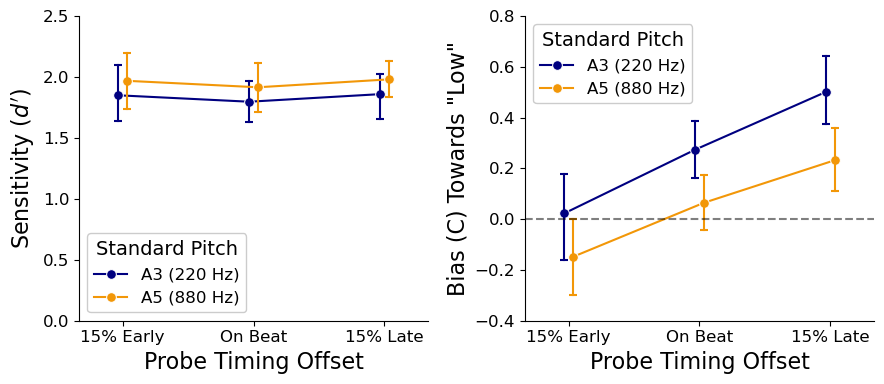

In [9]:
###
# Sensitivity
###

plt.subplot(121)

# Plot average d' per condition
sns.lineplot(x='offset', y='dprime', hue='octave', data=within_scores,
             hue_order=[3, 5], palette=[color5, color6],
             ls='-', lw=lw, marker='o', ms=msize,
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))
#plt.axhline(0, ls='--', c='k', alpha=.5)


# Stylize subplot
plt.legend(['A3 (220 Hz)', 'A5 (880 Hz)'], title='Standard Pitch', loc='lower left', framealpha=1)
plt.xlim(-20, 20)
plt.xticks([-15, 0, 15], ['15% Early', 'On Beat', '15% Late'])
plt.ylim(0, 2.5)
plt.xlabel('Probe Timing Offset')
plt.ylabel('Sensitivity ($d^\prime$)')


###
# Bias
###

plt.subplot(122)

# Plot average C per condition
sns.lineplot(x='offset', y='C', hue='octave', data=within_scores,
             hue_order=[3, 5], palette=[color5, color6],
             ls='-', lw=lw, marker='o', ms=msize,
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))
plt.axhline(0, ls='--', c='k', alpha=.5)


# Stylize subplot
plt.legend(['A3 (220 Hz)', 'A5 (880 Hz)'], title='Standard Pitch', loc='upper left', framealpha=1)
plt.xlim(-20, 20)
plt.xticks([-15, 0, 15], ['15% Early', 'On Beat', '15% Late'])
plt.ylim(-.4, .8)
plt.xlabel('Probe Timing Offset')
plt.ylabel('Bias (C) Towards "Low"')

# Stylize figure and save
plt.gcf().set_size_inches(9, 4)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'scores.svg')
plt.gcf().savefig(FIGURE_PATH + 'scores.pdf')

### Plot reaction time

In [10]:
# Load trial data from correct trials
data = pd.read_csv(TRIAL_DATAFILE)
data = data[~np.isin(data.subject, EXCLUDED)]
data = data[data.correct]

# Exclude trials with reaction times slower than 5 seconds
rt_thresh = 5000
bad_rt = data.rt > rt_thresh
print('Excluding %s percent of trials for outlier RT of at least %s ms' % (bad_rt.mean() * 100, rt_thresh))
data = data[~bad_rt]

# Add column coding response types as bias conforming, opposing, or neutral
data['response_type'] = ''
bias_conforming_mask = ((data.offset == -15).astype(int) + (data.pitch_shift=='+').astype(int)) % 2 == 0
data.loc[bias_conforming_mask, 'response_type'] = 'conforming'
data.loc[~bias_conforming_mask, 'response_type'] = 'opposing'
neutral_mask = data.offset == 0
data.loc[neutral_mask, 'response_type'] = 'neutral'

# Get subject averages for each response type
type_data = data.groupby(['subject', 'response_type']).mean(numeric_only=True).reset_index()

# Loftus & Masson (1994) method of plotting within-subject effects for main RT figure
cond_means = data.groupby(['subject', 'offset', 'pitch_shift']).mean(numeric_only=True).reset_index()
subj_means = cond_means.groupby('subject').mean(numeric_only=True).reset_index()
grand_mean = subj_means.mean()
within_data1 = cond_means.copy()
for i, subj in enumerate(subj_means.subject):
    within_data1.loc[within_data1.subject == subj, 'rt'] -= subj_means.rt[i] - grand_mean.rt

# Stagger the x-axis values so error bars will be easier to read
within_data1.loc[within_data1.pitch_shift == '+', 'offset'] -= .5
within_data1.loc[within_data1.pitch_shift == '-', 'offset'] += .5

Excluding 1.5832805573147564 percent of trials for outlier RT of at least 5000 ms


In [11]:
#colours for box plot
color7 = '#93c47d'
color8 = '#7d93c4'
color9 = '#c47d93'

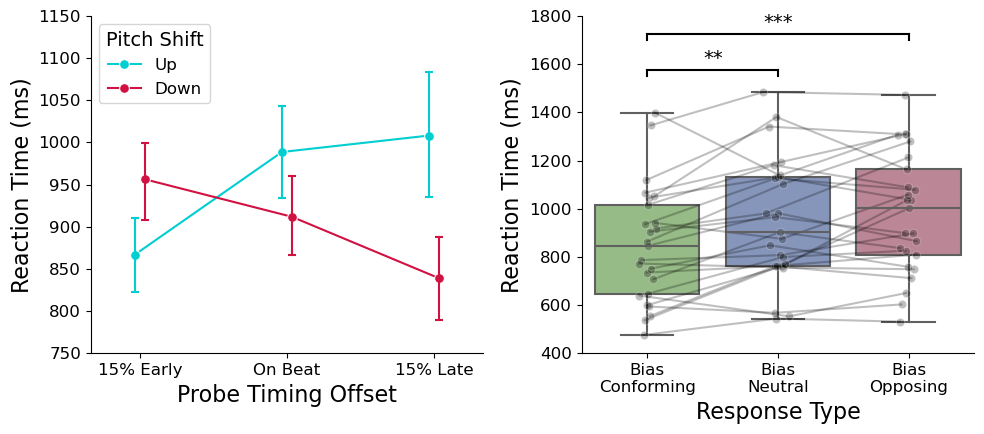

In [12]:
plt.subplot(121)

sns.lineplot(x='offset', y='rt', hue='pitch_shift', data=within_data1,
             ls='-', lw=lw, marker='o', ms=msize, hue_order=['+', '-'], palette=[color3, color4],
             err_style='bars', err_kws=dict(capsize=capsize, lw=lw, capthick=lw))

plt.xlabel('Probe Timing Offset')
plt.ylabel('Reaction Time (ms)')
plt.legend(['Up', 'Down'], title='Pitch Shift', loc='upper left')
plt.xlim(-20, 20)
plt.xticks([-15, 0, 15], ['15% Early', 'On Beat', '15% Late'])
plt.ylim(750, 1150)

plt.subplot(122)

sns.boxplot(x='response_type', y='rt', data=type_data, order=['conforming', 'neutral', 'opposing'], palette=[color7, color8, color9])
type_map = {'conforming': 0, 'neutral': 1, 'opposing': 2}
for s in type_data.subject.unique():
    sdata = type_data[type_data.subject == s]
    sns.lineplot(x=[type_map[x] + np.random.normal(0, .04) for x in sdata.response_type], y='rt', data=sdata,
                 color=text_color, alpha=.25, marker='o', ms=msize*.85, lw=lw)

plt.text(.43, 1600, '**', fontsize=14)
plt.plot([0, 1], [1575, 1575], c=text_color)
plt.plot([0, 0], [1550, 1575], c=text_color)
plt.plot([1, 1], [1550, 1575], c=text_color)

plt.text(.89, 1750, '***', fontsize=14)
plt.plot([0, 2], [1725, 1725], c=text_color)
plt.plot([0, 0], [1700, 1725], c=text_color)
plt.plot([2, 2], [1700, 1725], c=text_color)
    
plt.xlabel('Response Type')
plt.ylabel('Reaction Time (ms)')
#plt.xlim(-20, 20)
plt.xticks([0, 1, 2], ['Bias\nConforming', 'Bias\nNeutral', 'Bias\nOpposing'])
plt.ylim(400, 1800)


# Stylize figure and save
plt.gcf().set_size_inches(10, 4.5)
plt.tight_layout()
plt.gcf().savefig(FIGURE_PATH + 'rt.svg')
plt.gcf().savefig(FIGURE_PATH + 'rt.pdf')

### Plot sensitivity and bias correlation

In [13]:
# Load subject data
sdata = pd.read_csv(SUBJ_SCORES_DATAFILE)

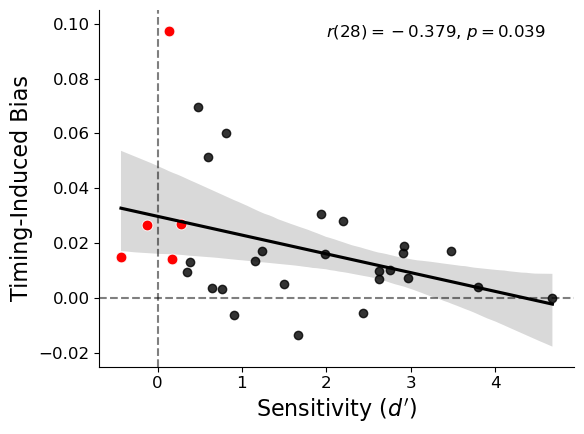

In [14]:
sns.regplot(x='dprime', y='C_slope', data=sdata, color=text_color)
sns.scatterplot(x='dprime', y='C_slope', data=sdata[np.isin(sdata.subject, EXCLUDED)], color='r', s=60)
plt.axhline(y=0, linestyle='--', color=text_color, alpha=.5)
plt.axvline(x=0, linestyle='--', color=text_color, alpha=.5)
r, p = stats.pearsonr(sdata.dprime, sdata.C_slope)
plt.text(2, .095, '$r(28)=%.03f$, $p=%.03f$' % (r, p))

plt.xlabel('Sensitivity ($d^\prime$)')
plt.ylabel('Timing-Induced Bias')
plt.ylim(-.025, .105)
plt.gcf().set_size_inches(6, 4.5)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'correlation.svg')
plt.savefig(FIGURE_PATH + 'correlation.pdf')